In [437]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random as ra
import math

from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

In [438]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1 #binary for whether it is digit or not
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [439]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [440]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [441]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [442]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [443]:
file_pth = 'binary_ffn_3.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained
trained_dig = int(file_pth[-5])

In [444]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        mask = (labels == trained_dig)
        if not mask.any():
            continue
        images = images[mask]
        if CUDA:
            images = images.cuda()
        images = images.view(-1, 28*28)

        a0 = F.tanh(net.fc0(images))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)
        predicted = (torch.sigmoid(logits) >= 0.5).float()

        correct += predicted.sum().item()
        total += images.size(0)

    print(f'Accuracy on digit {trained_dig} (manual pass with activations): {100 * correct / total:.2f} %')


Accuracy on digit 3 (manual pass with activations): 99.31 %


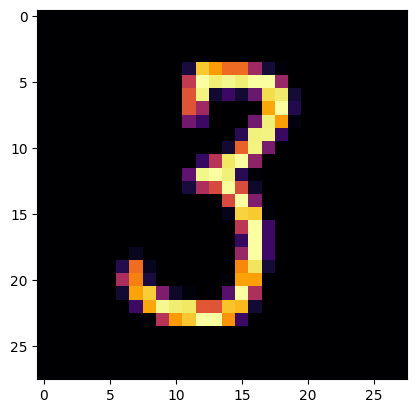

In [445]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == trained_dig:
        img = inputs[ind].squeeze()
        break

plt.imshow(img, cmap="inferno")


In [446]:
pixel_count_important = (img > 0).sum().item()
segment_size = round(pixel_count_important * 0.04, 0)

imp_pixels = (img > 0.5).nonzero(as_tuple=False) #tensor of coordiantes that aren't = 0 (just which pixels are to be clustered)

pixel_count_important, segment_size


(117, 5.0)

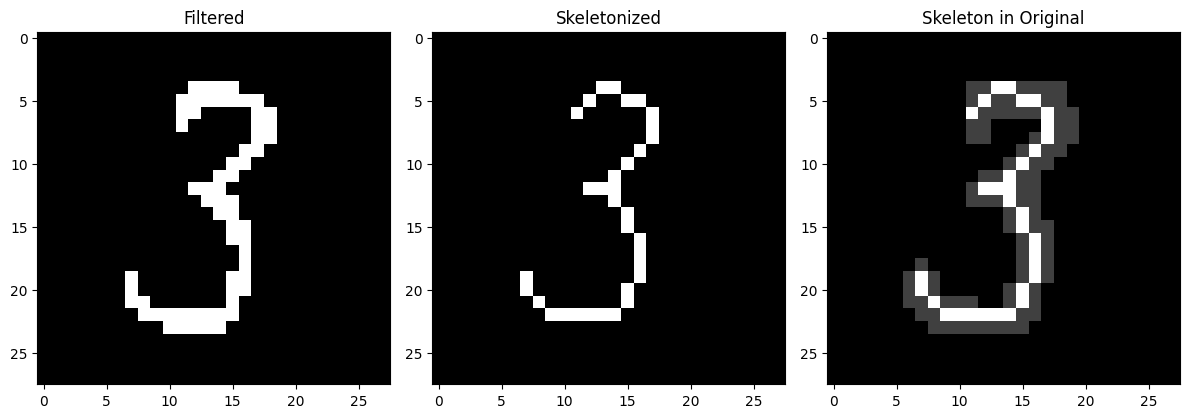

In [448]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize


"""inputs, labels = next(iter(test_loader))
dig_to_check = ra.randint(0, 9)

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break"""


img_np = img.cpu().numpy()
filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

skeleton = skeletonize(filtered)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Filtered")
plt.imshow(filtered, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Skeletonized")
plt.imshow(skeleton, cmap='gray')

#is this better than the other method??? update: yeah it actually is, screw the other one


actual = torch.where(
    img == 0,
    torch.tensor(0.0, device=img.device),
    0.25
)

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1

plt.subplot(1, 3, 3)
plt.title("Skeleton in Original")
plt.imshow(actual, cmap="gray")

plt.tight_layout()
plt.show()

Found 266 concept clusters


/tmp/ipykernel_8073/1703936991.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img, device=img.device),


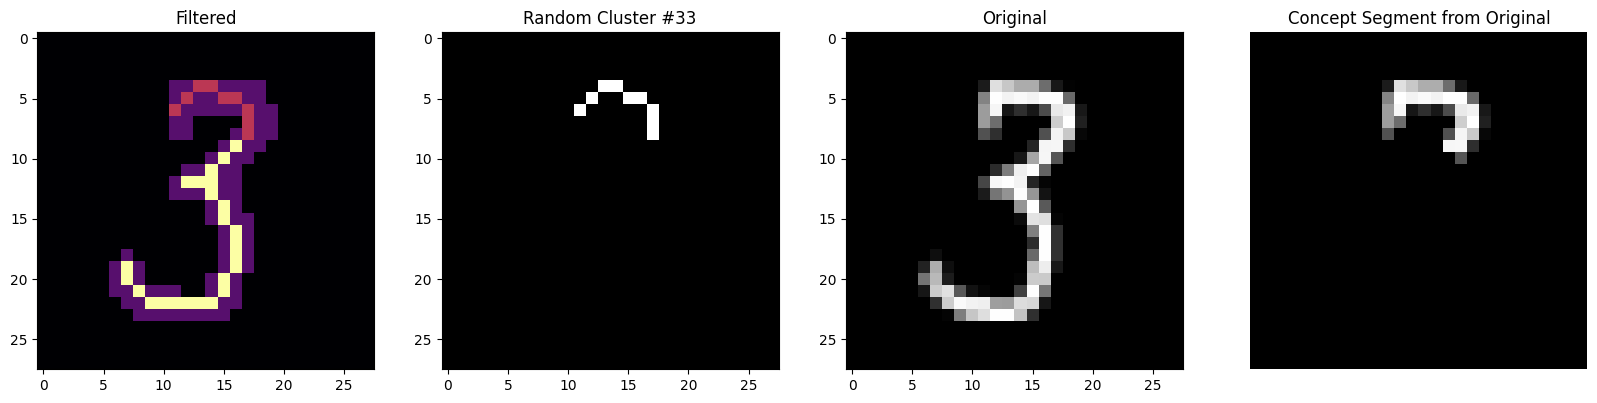

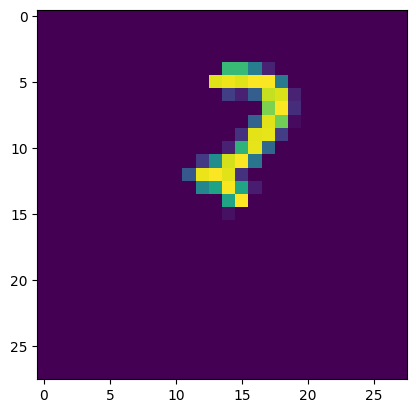

In [449]:
import networkx as nx
from scipy.ndimage import distance_transform_edt

def build_pixel_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape
    for i in range(rows):
        for j in range(cols):
            if skeleton[i, j]:
                G.add_node((i, j))
                for dx in [-1, 0, 1]: #8 neighbors
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < rows and 0 <= nj < cols and skeleton[ni, nj]:
                            G.add_edge((i, j), (ni, nj))
    return G

def find_clusters(G, min_size=5, max_size=10):
    clusters = []
    seen = set()

    def dfs(node, cluster, visited):
        if len(cluster) > max_size:
            return
        cluster_key = tuple(sorted(cluster))
        if cluster_key not in seen and min_size <= len(cluster) <= max_size:
            seen.add(cluster_key)
            clusters.append(cluster.copy())

        for neighbor in G[node]:
            if neighbor not in visited:
                dfs(neighbor, cluster + [neighbor], visited | {neighbor})

    for node in G.nodes:
        dfs(node, [node], set([node]))

    return clusters

def clusters_to_tensor(clusters, shape=(28, 28)):
    masks = []
    for cluster in clusters:
        mask = np.zeros(shape, dtype=np.uint8)
        for (i, j) in cluster:
            mask[i, j] = 1
        masks.append(mask)
    return torch.tensor(np.stack(masks), dtype=torch.uint8).permute(1, 2, 0)

#clustering
G = build_pixel_graph(skeleton)
clusters = find_clusters(G, min_size=5, max_size=10)
cluster_tensor = clusters_to_tensor(clusters) #[28, 28, n]



#plotting stuff:
print(f"Found {cluster_tensor.shape[2]} concept clusters")

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1.0

rand_idx = ra.randint(0, cluster_tensor.shape[2] - 1)
cluster_mask = cluster_tensor[:, :, rand_idx].numpy()
for y, x in np.argwhere(cluster_mask == 1):
    actual[y, x] = 0.5

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Filtered")
plt.imshow(actual, cmap='inferno')

plt.subplot(1, 4, 2)
plt.title(f'Random Cluster #{rand_idx}')
plt.imshow(cluster_tensor[:, :, rand_idx], cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Original')
plt.imshow(img, cmap='gray')

img2 = torch.where(
    img != 0,
    torch.tensor(img, device=img.device),
    0.0
)

inverted_mask = 1 - cluster_mask #cluster mask must be binary for the following methods btw
distance = distance_transform_edt(inverted_mask)
within_range_mask = (distance <= 2).astype(np.float32)
img2 = torch.from_numpy(img_np * within_range_mask) #back to tensor cause I'll give it to the model

plt.subplot(1, 4, 4)
plt.title('Concept Segment from Original')
plt.imshow(img2, cmap='gray')

plt.axis('off')
plt.show()


original_clusters = torch.zeros_like(cluster_tensor)
original_clusters = []

for i in range(cluster_tensor.shape[2]):
    mask = cluster_tensor[:, :, i].numpy()
    inverted_mask = 1 - mask
    distance = distance_transform_edt(inverted_mask)
    within_range_mask = (distance <= 2).astype(np.float32)
    new_input = torch.from_numpy(img_np * within_range_mask).float()
    original_clusters.append(new_input)
    
plt.imshow(original_clusters[ra.randint(0, cluster_tensor.shape[2])])



While doing the segmentation search on the original input would have also worked, it would have been far less efficient, as it would have also tried out different lanes on the (topologically) R¹ structure, in other words: it would have been R²

In [450]:
#don't forget to add lines or even smooth functions (instead of pixels) later for cleaner visualisation!
#now find concepts of cluster combinations that optimally activate the FFN final predcition probability distributions!

In [451]:
#model prep, no eval:

with torch.no_grad():
    activations_this_class = []
    for input_mat in original_clusters:
        if CUDA:
            input_mat = input_mat.cuda()

        a0 = F.tanh(net.fc0(input_mat.float().view(-1)))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)
        predicted = (torch.sigmoid(logits) >= 0.5).float()

        activations_this_class.append(logits)

        print(logits)

    print(activations_this_class)

tensor([3.1229], device='cuda:0')
tensor([4.9471], device='cuda:0')
tensor([5.5781], device='cuda:0')
tensor([5.6455], device='cuda:0')
tensor([6.1661], device='cuda:0')
tensor([6.7076], device='cuda:0')
tensor([4.5754], device='cuda:0')
tensor([5.4264], device='cuda:0')
tensor([5.5959], device='cuda:0')
tensor([6.1392], device='cuda:0')
tensor([6.6359], device='cuda:0')
tensor([6.3517], device='cuda:0')
tensor([6.5052], device='cuda:0')
tensor([3.1799], device='cuda:0')
tensor([3.0806], device='cuda:0')
tensor([4.7016], device='cuda:0')
tensor([5.3491], device='cuda:0')
tensor([5.5387], device='cuda:0')
tensor([6.1348], device='cuda:0')
tensor([2.8672], device='cuda:0')
tensor([4.6483], device='cuda:0')
tensor([5.0946], device='cuda:0')
tensor([5.7840], device='cuda:0')
tensor([6.3208], device='cuda:0')
tensor([5.9374], device='cuda:0')
tensor([5.9073], device='cuda:0')
tensor([5.9435], device='cuda:0')
tensor([5.8868], device='cuda:0')
tensor([6.1219], device='cuda:0')
tensor([5.9584

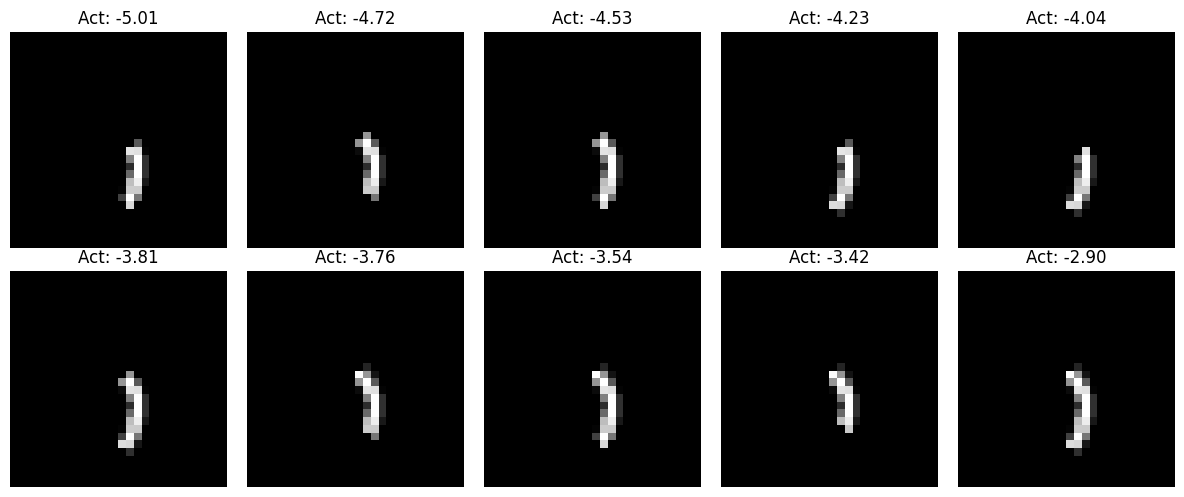

In [452]:
#get highest actiations and plot the corresponding img:

activations = torch.tensor([a.item() for a in activations_this_class])
top10_values, top10_indices = torch.topk(activations, 10, largest=False)

top10_tensors = [original_clusters[idx] for idx in top10_indices]

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    im = top10_tensors[i]
    ax.imshow(im.numpy(), cmap='gray')
    ax.set_title(f"Act: {top10_values[i]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
#next problem: many concepts overlap, but I do see which combnations of pixels that form low-level concepts have the most influence and in what direction they do
#--> I have to find these concepts that cover the entire digit and have the stringest influence in either direction (either class)















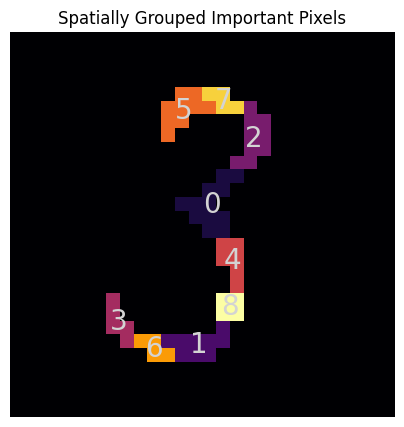

In [447]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=segment_size,
    linkage='complete',
    metric='euclidean'
)
labels = clusterer.fit_predict(imp_pixels) #apply clusterer to img

clusters = defaultdict(list)
for coord, label in zip(imp_pixels, labels):
    clusters[label].append(coord) #data structure to assign label to each group of pixles

#making a map
label_map = torch.zeros((28, 28), dtype=torch.int32)
for label, coords in clusters.items():
    for y, x in coords:
        label_map[y, x] = label + 1

label_map_np = label_map.numpy()
unique_vals = np.unique(label_map_np)

plt.figure(figsize=(5, 5))
plt.imshow(label_map_np, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Spatially Grouped Important Pixels')

for val in unique_vals:
    positions = np.argwhere(label_map_np == val)
    if positions.size == 0 or val == 0:
        continue
    centroid = positions.mean(axis=0)
    y, x = centroid
    plt.text(x, y, str(val-1), color='lightgray', fontsize=20, ha='center', va='center')

plt.show()


In [453]:
from scipy.ndimage import binary_dilation

#centroids
centroids = {}
for label, coords in clusters.items():
    centroids[label] = np.mean(coords, axis=0)  #(y,x) because np, matplot etc... order by row then column -> y then x

#touch detection
structure = np.ones((3,3), dtype=bool) #bin dilation checks for all 8 connected neighbors, therefore 3x3
touching = set()
for l1, c1 in clusters.items():
    mask = np.zeros((28,28), dtype=bool)
    for y,x in c1: mask[y,x]=1
    dil = binary_dilation(mask, structure=structure)
    for l2, c2 in clusters.items():
        if l1>=l2: continue
        if any(dil[y,x] for y,x in c2): touching.add((l1,l2)) #which labels touch

#centroid map
centroid_map = torch.zeros((28,28), dtype=torch.float32)
for l, (y,x) in centroids.items():
    centroid_map[int(y), int(x)] = 1

#plot map
plt.figure(figsize=(5,5))
plt.imshow(centroid_map, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Centroid Map with Connections')

#draw lines
for l1,l2 in touching:
    y1,x1 = centroids[l1]
    y2,x2 = centroids[l2]
    plt.plot([x1,x2], [y1,y2], color='white', linewidth=1)


AttributeError: 'list' object has no attribute 'items'

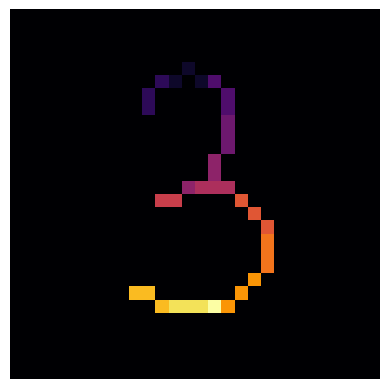

In [ ]:
used = set()
groups = []
pixels = set(zip(y_true, x_true))

for y, x in zip(y_true, x_true):
    if (y, x) in used:
        continue
    
    group = [(y, x)]
    used.add((y, x))
    
    for ny, nx in [(y+i, x+j) for i in [-1,0,1] for j in [-1,0,1]]: #check all 8 neighbors
        if (ny, nx) not in used and 0 <= ny < 28 and 0 <= nx < 28 and (ny, nx) in pixels:
            group.append((ny, nx))
            used.add((ny, nx))
    
    if len(group) < 3:
        for ny, nx in [(y+i, x+j) for i in range(-2,3) for j in range(-2,3)]: #checking 14 neighbors in next outer layer
            if len(group) >= 3: #try exactly 3
                break
            if (ny, nx) not in used and 0 <= ny < 28 and 0 <= nx < 28 and (ny, nx) in pixels:
                group.append((ny, nx))
                used.add((ny, nx))
    
    groups.append(group)

color_map = np.zeros((28, 28))
for n, group in enumerate(groups):
    for y, x in group:
        color_map[y, x] = n + 1

plt.imshow(color_map, cmap='inferno')
plt.axis('off')
plt.show()
